# 用Tensorflow2实现GCN

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx

import tensorflow as tf
from tensorflow import keras

## 1. 导入数据（**同质有向属性图**）

采用Cora数据集。该数据集是一个论文图，共2708个节点，，每个节点都是一篇论文，所有样本点被分为7类别：

1. Case_Based
2. Genetic_Algorithms
3. Neural_Networks
4. Probabilistic_Methods
5. Reinforcement_Learning
6. Rule_Learning
7. Theory

每篇论文都由一个**1433维的词向量表**示，即节点特征维度为1433。词向量的每个特征都对应一个词，取0表示该特征对应的词不在论文中，取1则表示在论文中。每篇论文都至少引用了一篇其他论文，或者被其他论文引用，这是一个连通图，不存在孤立点。

**图属性**：

- **节点数**：2708
- **边数**：5429

目的：通过GCN和图结构学习各节点的表示，然后进行**节点分类任务**

In [2]:
content_path = '../datasets/cora/cora.content'
cite_path = '../datasets/cora/cora.cites'

In [3]:
os.path.exists(content_path), os.path.exists(cite_path)

(True, True)

原始数据分别存于变量`contents`, `cites`

In [20]:
with open(content_path, 'r') as f:
    contents = f.readlines()
with open(cite_path, 'r') as f:
    cites = f.readlines()
contents = np.array([l.strip().split('\t') for l in contents])
cites_raw = np.array([i.strip().split('\t') for i in cites])

In [21]:
contents, cites_raw

(array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
        ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
        ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
        ...,
        ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
        ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
        ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
       dtype='<U22'),
 array([['35', '1033'],
        ['35', '103482'],
        ['35', '103515'],
        ...,
        ['853118', '1140289'],
        ['853155', '853118'],
        ['954315', '1155073']], dtype='<U7'))

In [34]:
contents.shape, cites_raw.shape

((2708, 1435), (5429, 2))

## 2. 数据预处理

对原始数据进行预处理，提取有效信息

In [156]:
# 分割数据，第二个参数是分割点，也可以使用np.hsplit，就不用指定axis
papers_raw, features_raw, labels_raw = np.split(contents, [1, -1], axis=1)

In [157]:
papers_raw.shape, features_raw.shape, labels_raw.shape

((2708, 1), (2708, 1433), (2708, 1))

In [208]:
features = features_raw.astype(np.float32)

建立一个**映射字典**，值为自然序数，键为论文代号

同样建立一个字典，值为自然序数，键为论文类别

In [18]:
paper_dict = {key:value for value, key in enumerate(np.squeeze(papers_raw))}
label_dict = {key:value for value, key in enumerate(np.unique(np.squeeze(labels_raw)))}

将论文和论文类别通过字典进行映射，同时将引用中的论文也通过字典进行映射

In [443]:
papers = np.array([[paper_dict[key]] for key in papers_raw.reshape(-1)])
labels = np.array([[label_dict[key]] for key in labels_raw.reshape(-1)])

In [22]:
cites = np.array([[paper_dict[i[0]], paper_dict[i[1]]] for i in cites_raw])

引用数据为单向的，为了构建**双向边**，将引用数据反转一次边后连接起来，此时边数变为了原来的两倍

In [38]:
node_num = len(papers)
label_num = len(label_dict.keys())
feature_dim = features.shape[1]
edge_num = len(cites)

In [39]:
print('{:=^30}'.format('图数据信息'))
print('节点数量：', node_num)
print('边数量：', edge_num)
print('特征维数：', feature_dim)
print('标签类别数量：', label_num)
print('标签类别：')
for label in label_dict.keys():
    print('{: <5}- {:<}'.format('', label))

============图数据信息=============
节点数量： 2708
边数量： 5429
特征维数： 1433
标签种类数量： 7
标签种类：
     - Case_Based
     - Genetic_Algorithms
     - Neural_Networks
     - Probabilistic_Methods
     - Reinforcement_Learning
     - Rule_Learning
     - Theory


## 3. 构造特定数据

### 3.1 构造图相关数据
通过networx构建图数据，便于快速得到邻接矩阵和其它图上数据

In [40]:
G = nx.Graph()
G.add_nodes_from(range(len(papers)))
G.add_edges_from(cites)
adj_matrix = nx.adjacency_matrix(G)

In [44]:
adj_matrix.shape, type(adj_matrix)

((2708, 2708), scipy.sparse.csr.csr_matrix)

In [42]:
np.array(adj_matrix.sum(axis=0)).flatten()

array([5, 1, 4, ..., 4, 4, 3], dtype=int64)

### 3.2 构造正规化邻居矩阵

邻接矩阵**正规化函数**，返回值对应论文中的：
$$
\hat A = D^{-1/2}(A+I)D^{-1/2}
$$

In [65]:
A = adj_matrix.toarray()
D_ = np.diag(np.power(A.sum(axis=0), -0.5))
A_hat = D_ @ (A + np.eye(A.shape[0])) @ D_

## 4. 数据分割

由于图数据的特殊性，无法直接进行分割，需要通过掩码的方式，按照6:2:2分为训练集、验证集、测试集

In [82]:
print(f'节点数：{node_num}')

节点数：2708


In [560]:
train_mask = np.zeros(node_num, dtype=np.uint8)
val_mask = np.zeros(node_num, dtype=np.uint8)
test_mask = np.zeros(node_num, dtype=np.uint8)
pivot1, pivot2 = int(0.6 * node_num), int(0.8 * node_num)
train_mask[:pivot1] = 1
val_mask[pivot1:pivot2] = 1
test_mask[pivot2:] = 1
train_mask = tf.cast(train_mask, tf.bool)
val_mask = tf.cast(val_mask, tf.bool)
test_mask = tf.cast(test_mask, tf.bool)

## 5. 模型构建

Tensorflow中暂时没有图神经网络的调用层或模型，需要自己进行实现

### 5.1 GCN模型层构造

计算：
状态转移方程
$$
H^n = \sigma(\hat A H^{n-1} W^{n-1})
$$
其中$\hat A$为正规化邻接矩阵，计算如下：
$$
\hat A = D^{-1/2}(A+I)D^{-1/2}
$$

In [85]:
class GCN_conv(keras.layers.Layer):
    def __init__(self, units, activation, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units, ),
                                initializer='random_normal', trainable=True)
        
    def call(self, inputs, A_hat):
        return self.activation(A_hat @ inputs @ self.W + self.b)

### 5.2 GCN模型构造

通过keras的模型构造方式构造即可

In [628]:
class GCN(keras.Model):
    def __init__(self, A_hat, input_shape, output_units, hidden_nums, activations, **kwargs):
        super().__init__(**kwargs)
        self.A_hat = A_hat
        self.input_layer = keras.layers.Input(shape=input_shape)
        self.gcn_conv = []
        self.drop_out = []
        for units, activation in zip(hidden_nums, activations):
            self.gcn_conv.append(GCN_conv(units, activation))
            self.drop_out.append(keras.layers.Dropout(0.2))
        self.dense = keras.layers.Dense(units=output_units, activation='softmax')
        
    def call(self, X):
        z = X
        for i in range(len(self.gcn_conv)):
            z = self.gcn_conv[i](z, self.A_hat)
            z = self.drop_out[i](z)
        
#         for gcn_conv, drop_out in zip(self.gcn_conv, self.drop_out):
#             z = gcn_conv(z, self.A_hat)
#             z = drop_out(z)
        z = self.dense(z)
        return z

## 6. 模型训练与评估

先构造两个函数，损失函数和准确率函数，之后简单的定义一下训练结构，进行训练、评估、可视化

### 6.1 构建损失函数和评估指标

损失函数选择多元交叉熵，评估指标为准确率

In [592]:
def masked_sparse_cross_entropy(preds, labels, mask):
    """预测结果是概率形式，标签是正确类型，计算"""
    loss = - tf.math.log(tf.clip_by_value(preds[mask], 1e-7, 1)) * tf.one_hot(labels[mask].ravel(), 7)
    loss = tf.reduce_sum(loss, axis=1)
    loss = tf.reduce_mean(loss)
    '''
    或者
    keras.losses.SparseCategoricalCrossentropy(from_logits=False)(labels[mask], preds[mask])
    '''
    return loss

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct = tf.equal(tf.argmax(preds[mask], axis=1), labels[mask].ravel())
    correct = tf.cast(correct, tf.float32)
    return tf.reduce_mean(correct)

In [631]:
model = GCN(A_hat.astype(np.float32), (feature_dim, ), label_num, [500, 200, 50], ['relu']*3)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
train_accs = []
val_accs = []
for epoch in range(30):
    with tf.GradientTape() as tape:
        logits = model(features, training=True)
        loss = masked_sparse_cross_entropy(logits, labels, train_mask)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     if epoch % 10 == 0:
    print('{:=^30}'.format(f'Start of {epoch+1}'))
    acc_train = masked_accuracy(logits, labels, train_mask)
    acc_val = masked_accuracy(logits, labels, val_mask)
    train_accs.append(acc_train.numpy())
    val_accs.append(acc_val.numpy())
    print('训练集准确率：', acc_train.numpy(), end='')
    print('; 验证集准确率：', acc_val.numpy())
logits = model(features, training=False)
acc_test = masked_accuracy(logits, labels, test_mask)
print('训练集准确率：', acc_test.numpy())

==========Start of 1==========
训练集准确率： 0.18780789; 验证集准确率： 0.199262
==========Start of 2==========
训练集准确率： 0.30788177; 验证集准确率： 0.28597787
==========Start of 3==========
训练集准确率： 0.16502462; 验证集准确率： 0.19557196
==========Start of 4==========
训练集准确率： 0.38916257; 验证集准确率： 0.4298893
==========Start of 5==========
训练集准确率： 0.42179802; 验证集准确率： 0.4501845
==========Start of 6==========
训练集准确率： 0.5504926; 验证集准确率： 0.55535054
==========Start of 7==========
训练集准确率： 0.58928573; 验证集准确率： 0.5867159
==========Start of 8==========
训练集准确率： 0.6656404; 验证集准确率： 0.6715867
==========Start of 9==========
训练集准确率： 0.682266; 验证集准确率： 0.69926196
=========Start of 10==========
训练集准确率： 0.72167486; 验证集准确率： 0.71955717
=========Start of 11==========
训练集准确率： 0.7924877; 验证集准确率： 0.78044283
=========Start of 12==========
训练集准确率： 0.8368227; 验证集准确率： 0.7933579
=========Start of 13==========
训练集准确率： 0.8528325; 验证集准确率： 0.8173432
=========Start of 14==========
训练集准确率： 0.8756158; 验证集准确率： 0.82656825
=========Start of 15==========
训练集准确

**注**：分类准确率达到了81.18%，GCN原文中在Cora数据集上正确率为81.5%，基本吻合

### 6.1 训练结构可视化

很简单的可视化了一下准确率曲线

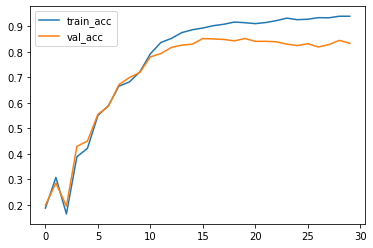

In [632]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.legend(['train_acc', 'val_acc'], loc='best')

### 6.2 模型结构和参数

数据节点只有2千多，参数就有了82万。

注：虽然是先创建了三个GCN层，再创建的三个Dropout层，但实际上训练时是经过一个GCN随后就经过一个Dropout，下面的结构有些偏差。

In [633]:
model.summary()

Model: "gcn_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gcn_conv_134 (GCN_conv)      multiple                  717000    
_________________________________________________________________
gcn_conv_135 (GCN_conv)      multiple                  100200    
_________________________________________________________________
gcn_conv_136 (GCN_conv)      multiple                  10050     
_________________________________________________________________
dropout_18 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
dense_43 (Dense)             multiple                  357  